In [97]:
import numpy as np
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [98]:
# Step 1: Extract images from ZIP file
zip_file_path = 'images.zip'  # Change this to your actual ZIP file path
extract_folder = 'extracted_images'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [133]:
# Check the contents of the extracted directory
images_dir = os.path.join(extract_folder, 'images')  # Adjust the path to your images folder
#print("Contents of extracted images directory:", os.listdir(images_dir))

In [135]:
# Step 2: Create a function to generate the label dictionary
def create_label_dict(images_dir):
    label_dict = {}
    for filename in os.listdir(images_dir):
        #print("Processing file:", filename)  # Debugging line
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Check file extension
            if '_r' in filename:
                label_dict[filename] = 0  # No illusion
            elif '_y-flip_r' in filename or '_x-flip_r' in filename:
                label_dict[filename] = 0  # No illusion but flipped
            elif filename.endswith('.jpg') and not ('_r' in filename or '_flip' in filename):
                label_dict[filename] = 1  # Illusion
            elif '_y-flip' in filename or '_x-flip' in filename:
                label_dict[filename] = 1  # Flipped illusion
            else:
                print(f"Unmatched condition for: {filename}")  # Debugging unmatched files
    return label_dict

In [138]:
# Step 3: Generate the label dictionary
label_dict = create_label_dict(images_dir);
#print("Label dictionary created:", label_dict)

# Prepare data for training, validation, and testing
data = [(filename, label) for filename, label in label_dict.items()];

# Shuffle and split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=31)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=31)  # 15% val, 15% test

# Output the sizes of the datasets
print("Training data:", len(train_data))
print("Validation data:", len(val_data))
print("Testing data:", len(test_data))

Training data: 142
Validation data: 31
Testing data: 31


In [102]:
# Step 4: Preprocess images and flatten them
def preprocess_images(data, images_dir, target_size=(150, 150)):
    images = []
    labels = []
    filenames = []
    for filename, label in data:
        img_path = os.path.join(images_dir, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array.flatten() / 255.0  # Flatten and normalize
        images.append(img_array)
        labels.append(label)
        filenames.append(filename)
    return np.array(images), np.array(labels), filenames

X_train, y_train, train_filenames = preprocess_images(train_data, images_dir)
X_val, y_val, val_filenames = preprocess_images(val_data, images_dir)
X_test, y_test, test_filenames = preprocess_images(test_data, images_dir)


In [103]:
# Step 5: Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)


In [104]:
# Step 6: Build FCN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the FCN architecture
def create_fcn_model(input_shape=(150, 150, 3)):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_shape,)),                  # Fully connected layer
        BatchNormalization(),
        Dropout(0.5),                                   # Dropout for regularization
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')                  # Sigmoid output layer for binary classification
    ])
    return model

# Instantiate the model
model = create_fcn_model(input_shape=X_train_pca.shape[1])

In [126]:
# Step 7: Compile and run FCN model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val), epochs=20, batch_size=32)

Epoch 1/20
5/5 [==============================] - 2s 55ms/step - loss: 0.4136 - accuracy: 0.7887 - val_loss: 0.6678 - val_accuracy: 0.7419
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.5378 - accuracy: 0.7324 - val_loss: 0.6496 - val_accuracy: 0.7419
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.4735 - accuracy: 0.7465 - val_loss: 0.6432 - val_accuracy: 0.7419
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.3902 - accuracy: 0.8028 - val_loss: 0.6386 - val_accuracy: 0.7419
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.4542 - accuracy: 0.7746 - val_loss: 0.6343 - val_accuracy: 0.7419
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.3802 - accuracy: 0.7817 - val_loss: 0.6364 - val_accuracy: 0.7419
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.4897 - accuracy: 0.8028 - val_loss: 0.6290 - val_accuracy: 0.7419
Epoch 8/20
5/5 [===========

In [127]:
# Step 8: Metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = (model.predict(X_test_pca) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

1/1 [==============================] - 0s 106ms/step
Test Accuracy: 0.8064516129032258
Confusion Matrix:
 [[12  2]
 [ 4 13]]


In [128]:
print(classification_report(y_test, y_pred, target_names=['Non-Illusion', 'Illusion']))

              precision    recall  f1-score   support

Non-Illusion       0.75      0.86      0.80        14
    Illusion       0.87      0.76      0.81        17

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



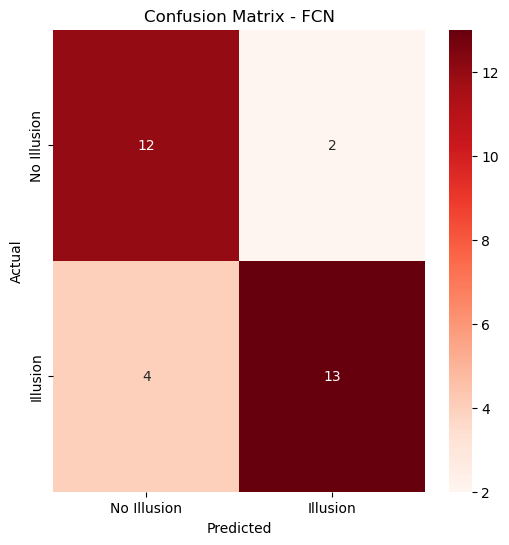

In [129]:
import seaborn as sns


def plot_confusion_matrix(cm, model_name, cmap):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["No Illusion", "Illusion"], yticklabels=["No Illusion", "Illusion"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(conf_matrix, "FCN", cmap="Reds")